# Detect news duplicates
## Prepare training data


In [6]:
import time
import nltk.data
import nltk
from tqdm import tqdm

In [7]:
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')    

def truncate_text(text:str, size=512) -> str:
    sentences = sent_detector.tokenize(text.strip())
    for i in range(len(sentences)+1):
        if len(' '.join(sentences[:i])) > size:
            return ' '.join(sentences[:max(i-1, 1)])
    return text

text = '''
Punkt knows that the periods in Mr. Smith and Johann S. Bach
do not mark sentence boundaries.  And sometimes sentences
can start with non-capitalized words.  i is a good variable
name.
'''

assert 'Punkt knows that the periods in Mr. Smith and Johann S. ' \
       'Bach\ndo not mark sentence boundaries. And sometimes sentences\ncan ' \
       'start with non-capitalized words.' == truncate_text(text, 155)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vslay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load and clean training data

In [8]:
import pandas as pd

def clean_data(df_news):
    df_news.index = df_news.index.rename('datetime')
    df_news = df_news.rename(columns={'related': 'topics'})
    df_news = df_news[df_news['lang'] == 'en'][['headline', 'summary', 'source', 'topics']].drop_duplicates()

    bad_headline = df_news.groupby('headline').count().query('source > 3').index
    bad_summary = df_news.groupby('summary').count().query('source > 3').index
    df_news = df_news[~df_news['summary'].isin(bad_summary) & ~df_news['headline'].isin(bad_headline)]

    df_news['topics'] = df_news['topics'].fillna('').apply(lambda v: set(v.split(',')))
    df_news = df_news[~df_news['summary'].str.startswith('http')]
    return df_news

df_news = pd.read_csv('data/news.csv.tgz', compression='gzip', index_col='news.csv', parse_dates=True)
df_news = clean_data(df_news)


C:\Users\vslay\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
<ipython-input-8-f972659f867f>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_news['topics'] = df_news['topics'].fillna('').apply(lambda v: set(v.split(',')))


In [9]:
def gen_news_duplicates_data(
        df: pd.DataFrame,
        truncate: int=512,
        negative_sample_min_time_difference: int=1 * 24 * 3600,
        negative_sample_max_time_difference: int=30 * 24 * 3600,
) -> pd.DataFrame:
    df = df[['headline', 'summary', 'topics']].copy()
    df['headline'] = df['headline'].apply(lambda s: truncate_text(s, truncate))
    df['summary'] = df['summary'].apply(lambda s: truncate_text(s, truncate))
    # positive samples
    df_positive = df.sample(frac=1.0).copy()
    df_positive['labels'] = 1
    df_positive = pd.concat([
        df_positive.head(len(df_positive) // 2),
        df_positive.tail(len(df_positive) // 2).rename(columns={
            'headline': 'summary',
            'summary': 'headline'
        })
    ])
    print(f'Generated {len(df_positive)} positive samples')
    # negative samples
    with tqdm(leave=False, mininterval=1, desc='Generating negative samples', total=len(df_positive)) as progress:
        df_negative = []
        for _, i1 in df.iterrows():
            df_sample = df[
                (
                    (df.index < i1.name - pd.Timedelta(seconds=negative_sample_min_time_difference)) &
                    (df.index > i1.name - pd.Timedelta(seconds=negative_sample_max_time_difference))
                ) | (
                    (df.index > i1.name + pd.Timedelta(seconds=negative_sample_min_time_difference)) &
                    (df.index < i1.name + pd.Timedelta(seconds=negative_sample_max_time_difference))
                )
            ]
            df_sample = df_sample[df_sample.apply(lambda v: len(v['topics'] & i1['topics']) > 0, axis=1)]
            if len(df_sample) == 0:
                continue
            i2 = df_sample.sample().iloc[0]
            time_diff = abs((i1.name - i2.name).total_seconds())

            if negative_sample_min_time_difference < time_diff < negative_sample_max_time_difference:
                df_negative.append({
                    'headline': i1['headline'],
                    'summary': i2['summary'],
                    'topics': i1['topics'] & i2['topics'],
                    'labels': 0
                })
                progress.update(1)
    df_negative = pd.DataFrame(df_negative)
    df_negative = pd.concat([
        df_negative.head(len(df_negative) // 2),
        df_negative.tail(len(df_negative) // 2).rename(columns={
            'headline': 'summary',
            'summary': 'headline'
        })])
    print(f'Generated {len(df_negative)} negative samples')

    df_duplicates = pd.concat([df_positive, df_negative]).sample(frac=1.0).reset_index(drop=True)
    return df_duplicates



gen_news_duplicates_data(df_news.head(1000))

Generating negative samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Generated 1000 positive samples


Generated 994 negative samples


,headline,summary,topics,labels
0,"Lehman, WorldCom And Now PG&E: The ""Failing An...",One week ago when we wrote that with PG&E faci...,{BAC},1
1,Google Moved $23 Billion To Bermuda Tax Haven ...,Qualcomm’s revenue is expected to decline for ...,{AAPL},0
2,Russia launched administrative action against ...,Watch Live: Yellow Vests Rage For 11th Straigh...,{FB},0
3,Facebook posted record profit in the fourth qu...,Facebook Reports Record Profit,{FB},1
4,Analysts Growing Bearish Ahead Of Earnings Fro...,Big banks Bank of America and Goldman Sachs re...,{BAC},1
...,...,...,...,...
1989,Zimbabwe is once again at the brink of economi...,Protests Erupt As Zimbabwe Now Has The Most Ex...,{FB},1
1990,The investment manager Parnassus Investments i...,Why a Big Investment Manager Bought Up Microso...,"{MSF, MSFT}",1
1991,"Macron Arrests ""Yellow Vest"" Organizer In Esca...",While this year's now-concluded World Economic...,{FB},0
1992,Why Momentum Traded Amazon and Apple for Coca-...,The iShares Edge MSCI USA Momentum Factor ETF ...,{KO},1


Generate training/test data

In [16]:
import os
if os.path.exists('data/news.train.csv.tgz'):
    df_duplicates_train = pd.read_csv('data/news.train.csv.tgz', compression='gzip')
else:
    print('Generating training data')
    df_duplicates_train = gen_news_duplicates_data(
        df_news[(df_news.index >= '2019-01-01') & (df_news.index < '2020-11-01')]
    )
    print('Training data', len(df_duplicates_train), 'samples')
    df_duplicates_train.to_csv('data/news.train.csv.tgz', compression='gzip', index=False)

    


In [18]:
if os.path.exists('data/news.test.csv.tgz'):
    df_duplicates_test = pd.read_csv('data/news.test.csv.tgz', compression='gzip')
else:
    print('Generating test data')
    df_duplicates_test = gen_news_duplicates_data(
        df_news[(df_news.index >= '2020-11-01') & (df_news.index < '2021-01-01')]
    )
    print('Test data', len(df_duplicates_test), 'samples')
    df_duplicates_test.to_csv('data/news.test.csv.tgz', compression='gzip', index=False)


## Train duplicates detection model

In [3]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import torch 
model_news_dup = ClassificationModel(
    'roberta',
    'roberta-base',
    num_labels=2,
    use_cuda=True, 
    cuda_device=0,
    args=ClassificationArgs(
        fp16=True, 
        dataloader_num_workers=1,        
        use_multiprocessing=False,
        use_multiprocessing_for_evaluation=False,
        
        # "RoBERTa: A Robustly Optimized BERT Pretraining Approach". Optimal batch size is 32, optimal LR=1e-5
        eval_batch_size=32,
        train_batch_size=32,
        overwrite_output_dir=True,
        num_train_epochs=1,
        reprocess_input_data=False,
        best_model_dir='model/roberta_news_duplicates',
        
        # disabling all LR improvements
        adafactor_relative_step=False,
        adafactor_scale_parameter=False,
        adafactor_warmup_init=False,
        polynomial_decay_schedule_lr_end=1e-5,
        learning_rate=1e-5,
        warmup_ratio=0.,
        
        use_early_stopping=False, 
        early_stopping_consider_epochs=True,
        early_stopping_patience=2,
        
        evaluate_during_training=True, 
        evaluate_during_training_verbose=True,
        evaluate_during_training_steps=2500,
        use_cached_eval_features=True,
        save_model_every_epoch=True,
        
        save_eval_checkpoints=False, 
        save_steps=100000000,
    )    
) 





Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

In [ ]:
model_news_dup.train_model(
    df_duplicates_train.rename(columns={'headline': 'text_a', 'summary': 'text_b'}),
    eval_df=df_duplicates_test.rename(columns={'headline': 'text_a', 'summary': 'text_b'}),
)

## Evaluation

In [21]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import torch 
model_news_dup = ClassificationModel(
    'roberta',
    'model/roberta_news_duplicates',
    use_cuda=torch.cuda.is_available(), 
    args=ClassificationArgs(
        fp16=True, 
        dataloader_num_workers=1,        
        use_multiprocessing_for_evaluation=False,
        eval_batch_size=32,
    )    
) 




In [22]:
model_news_dup.eval_model(
    df_duplicates_test.rename(columns={'headline': 'text_a', 'summary': 'text_b'})[['text_a', 'text_b','labels']]
)

({'mcc': 0.9071855999740813,
  'tp': 14653,
  'tn': 14461,
  'fp': 805,
  'fn': 613,
  'auroc': 0.9912327531775954,
  'auprc': 0.9915184749678183,
  'eval_loss': 0.14305145395493027},
 array([[-3.21679688,  3.45898438],
        [-3.16992188,  3.35742188],
        [-2.99609375,  3.08007812],
        ...,
        [-3.171875  ,  3.36132812],
        [-2.4140625 ,  2.28710938],
        [-3.22265625,  3.4609375 ]]),
 [])

In [24]:
pred1 = model_news_dup.predict(
    df_duplicates_test.rename(columns={'headline': 'text_a', 'summary': 'text_b'})[['text_a', 'text_b']].values.tolist()
)

pred2 = model_news_dup.predict(
    df_duplicates_test.rename(columns={'headline': 'text_b', 'summary': 'text_a'})[['text_a', 'text_b']].values.tolist()
)

In [34]:
print('Single test accuracy:', (pred1[0] == df_duplicates_test['labels']).mean(), (pred2[0] == df_duplicates_test['labels']).mean())

Single test accuracy: 0.953556923883139 0.9534259137953622


In [43]:
import numpy as np
print('Double test accuracy', np.mean(((pred1[0] == 1) & (pred2[0] == 1)) == df_duplicates_test['labels']))

Double test accuracy 0.9556858378095113


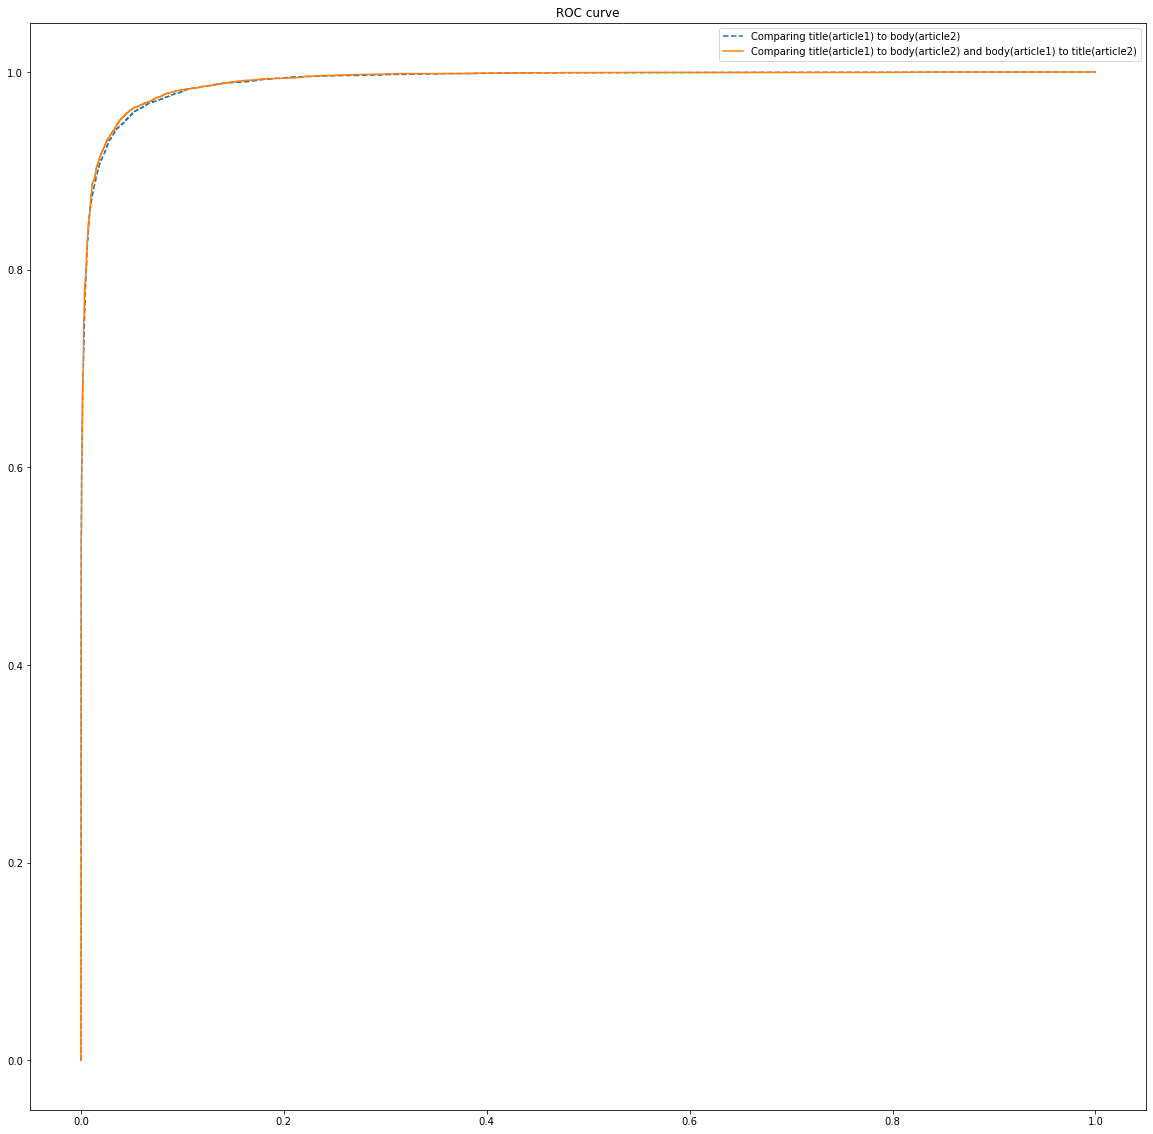

In [65]:
from sklearn.metrics import roc_curve, auc
from scipy.special import softmax
from matplotlib import pyplot



pyplot.figure(figsize=(20, 20))

fpr, tpr, _ = roc_curve(df_duplicates_test['labels'], softmax(pred1[1], axis=1)[:, 1])
pyplot.plot(fpr, tpr, linestyle='--', label='Comparing title(article1) to body(article2)')


fpr, tpr, _ = roc_curve(df_duplicates_test['labels'],  (softmax(pred1[1], axis=1)[:, 1] + softmax(pred2[1], axis=1)[:, 1]) / 2)
pyplot.plot(fpr, tpr, linestyle='-', label='Comparing title(article1) to body(article2) and body(article1) to title(article2)')
pyplot.title('ROC curve')
pyplot.legend()
pyplot.show()

# Predict

In [76]:
# Negative example
model_news_dup.predict([
    [
        'Coronavirus: Third wave will "wash up on our shores", warns Johnson', 
        'Some 18,000 people have been evacuated from severe floods across New South Wales (NSW) in Australia, with more heavy rainfall predicted.'
    ]
])[0]

array([0], dtype=int64)

In [77]:
# Positive example
model_news_dup.predict([
    [
        'Coronavirus: Third wave will "wash up on our shores", warns Johnson', 
        'Boris Johnson has warned the effects of a third wave of coronavirus will "wash up on our shores" from Europe. The PM said the UK should be "under no illusion" we will "feel effects" of growing cases on the continent'
    ]
])[0]

array([1], dtype=int64)